# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 35 s, sys: 3.73 s, total: 38.8 s
Wall time: 39.2 s


In [5]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

In [6]:
years = X_train.year.unique().tolist()
years

[2019, 2022]

In [7]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Run pipeline

In [8]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [9]:
columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']

class Config:
    num_attribs0 = ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4'] + columns_meteo # year
    cat_attribs0 = ['dayofyear', 'hour'] # dayofyear
    cat_attribs1 = ['station_id'] # dayofweek
    gen_attribs0 = ['festius_sun', 'weekend']
    target_col = ['ctx0']

    seed=42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [10]:
config=Config()
seed_everything(config.seed)

In [11]:
def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [12]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 29 µs, sys: 5 µs, total: 34 µs
Wall time: 36.2 µs


In [13]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('gen1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['festius_sun', 'weekend']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 ['dayofyear', 'hour']),
                                ('cat1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['station_id'])])

In [14]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

In [15]:
def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

In [16]:
def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


In [17]:
def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [18]:
def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [19]:
[months.remove(x) for x in [6,7,8,9]]

[None, None, None, None]

In [20]:
years, months

([2019, 2022], [1, 2, 3, 4, 5, 10, 11, 12])

In [21]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], months, True)


train
X (2357330, 68) X_prepared: (2357330, 421) y:  (2357330,)
val
X (586724, 68) X_prepared: (586724, 421) y:  (586724,)
test
X (359126, 68) X_prepared: (359126, 421) y:  (359126,)


# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [22]:
%%time 

lin_reg = LinearRegression(n_jobs=5)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 10.5 µs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished



  model test
Scores: [-0.11474478 -0.11456698 -0.11441393 -0.11506652 -0.11445061]
Mean: -0.11464856216682322
Standard deviation: 0.00023868028874851778

Training time: 0.058 s
----- EVALUATION ON VAL SET ------
MSE: 0.013138081768081473
RMSE 0.11462147167124262
MAE: 0.07664551261323999
R^2:  0.8078242450100978



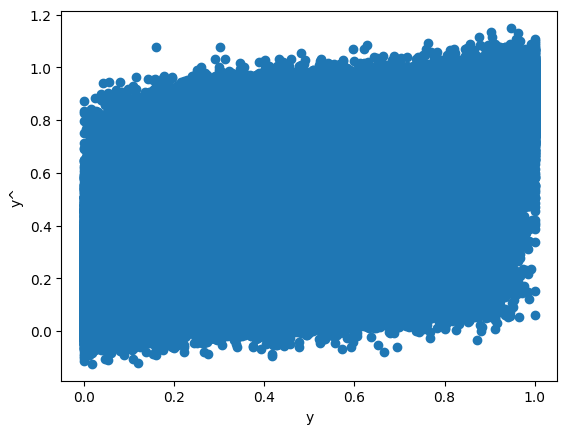


Training time: 0.011 s
----- EVALUATION ON VAL SET ------
MSE: 0.009653109385795547
RMSE 0.09825023860426776
MAE: 0.06634937328210355
R^2:  0.8523138362479494



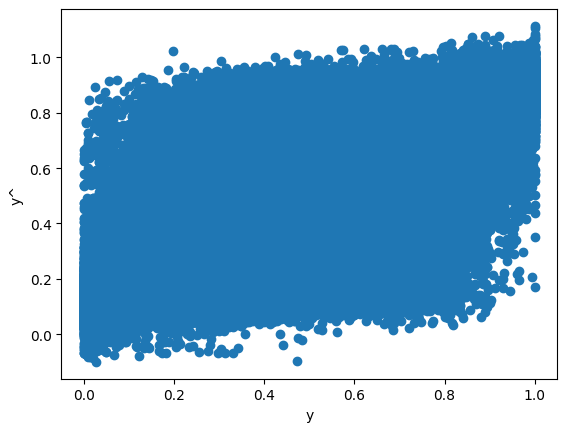


Testing time: 0.008 s
----- EVALUATION ON VAL SET ------
MSE: 0.013890489596135865
RMSE 0.11785792122778962
MAE: 0.08016045781842013
R^2:  0.8100854161884724



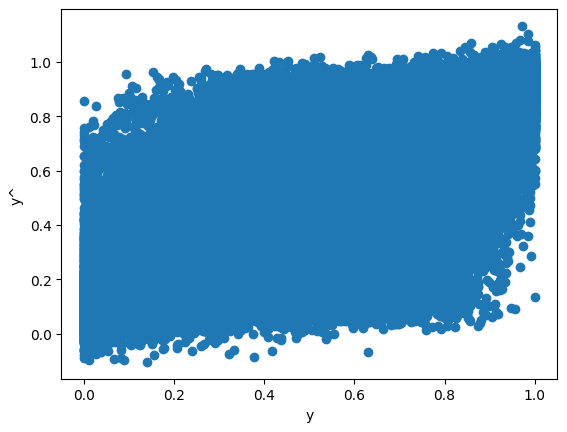

CPU times: user 14 s, sys: 28.3 s, total: 42.4 s
Wall time: 11.5 s


{'train': mse_t     0.013138
 rmse_t    0.114621
 mae_t     0.076646
 r2_t      0.807824
 dtype: object,
 'test': mse_t     0.009653
 rmse_t     0.09825
 mae_t     0.066349
 r2_t      0.852314
 mse_v      0.01389
 rmse_v    0.117858
 mae_v      0.08016
 r2_v      0.810085
 dtype: object}

In [23]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

In [24]:
%%time 

result = do_test_per_month(
    LinearRegression, dict(n_jobs=5),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 15.4 s, sys: 37.7 s, total: 53.1 s
Wall time: 6.65 s


<Axes: >

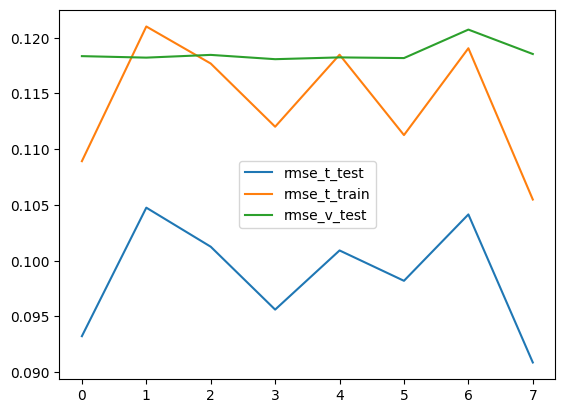

In [25]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [26]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.090876
rmse_t_train    0.105488
rmse_v_test     0.118073
dtype: object

In [27]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.868383
r2_t_train    0.831995
r2_v_test     0.809392
dtype: object

In [28]:
%%time 

result = do_test_per_month_combos(
    LinearRegression, dict(n_jobs=5),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 30 s, sys: 1min 13s, total: 1min 43s
Wall time: 12.7 s


<Axes: >

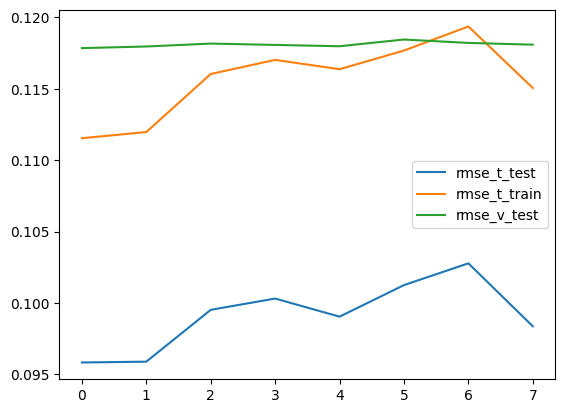

In [29]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [30]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.095838
rmse_t_train    0.111545
rmse_v_test     0.117855
dtype: object

In [31]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.856349
r2_t_train    0.815194
r2_v_test     0.810094
dtype: object

## KNN3
### Not ideal to store and sort large data.
https://www.kaggle.com/general/352216

## SVM 
### SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. 
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python#advantages

# Decision Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
%%time 

# define model 
tree_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=11, random_state=config.seed)


CPU times: user 15 µs, sys: 21 µs, total: 36 µs
Wall time: 40.1 µs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min finished



  model test
Scores: [-0.11226692 -0.11207272 -0.11177621 -0.11252056 -0.11180741]
Mean: -0.11208876338123316
Standard deviation: 0.0002811739715459951

Training time: 0.21 s
----- EVALUATION ON VAL SET ------
MSE: 0.012213795263249285
RMSE 0.110516040750876
MAE: 0.07324072417205021
R^2:  0.8213441377941904



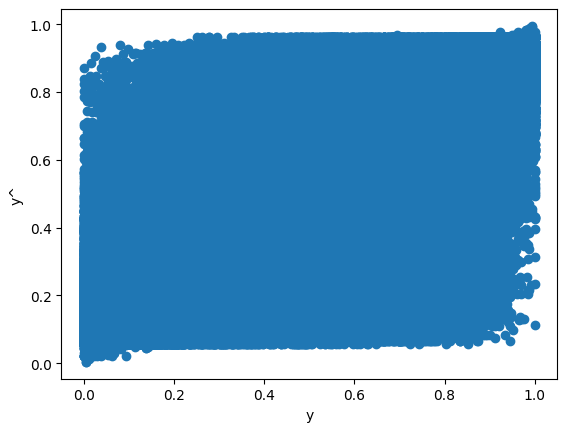


Training time: 0.05 s
----- EVALUATION ON VAL SET ------
MSE: 0.00885113971904578
RMSE 0.0940804959545058
MAE: 0.060051212273573164
R^2:  0.8645834396259103



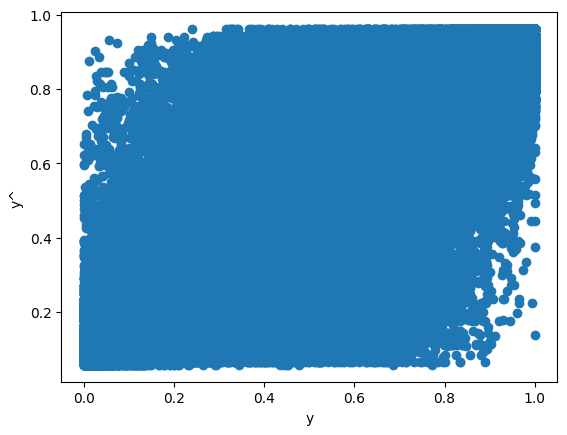


Testing time: 0.032 s
----- EVALUATION ON VAL SET ------
MSE: 0.01314782077760111
RMSE 0.11466394715690328
MAE: 0.07703373832784711
R^2:  0.8202393879837548



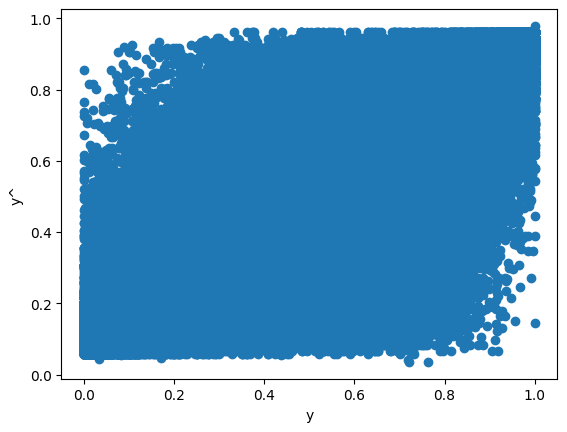

CPU times: user 1min 24s, sys: 551 ms, total: 1min 24s
Wall time: 2min 34s


{'train': mse_t     0.012214
 rmse_t    0.110516
 mae_t     0.073241
 r2_t      0.821344
 dtype: object,
 'test': mse_t     0.008851
 rmse_t     0.09408
 mae_t     0.060051
 r2_t      0.864583
 mse_v     0.013148
 rmse_v    0.114664
 mae_v     0.077034
 r2_v      0.820239
 dtype: object}

In [35]:
%%time 

test_model_train_val_test(
    tree_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.012214
#  rmse_t    0.110516
#  mae_t     0.073241
#  r2_t      0.821344
#  dtype: object,
#  'test': mse_t     0.008851
#  rmse_t     0.09408
#  mae_t     0.060051
#  r2_t      0.864583
#  mse_v     0.013148
#  rmse_v    0.114664
#  mae_v     0.077034
#  r2_v      0.820239
#  dtype: object}

In [36]:
%%time 

result = do_test_per_month(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 59.4 s, sys: 3.18 ms, total: 59.4 s
Wall time: 59.4 s


<Axes: >

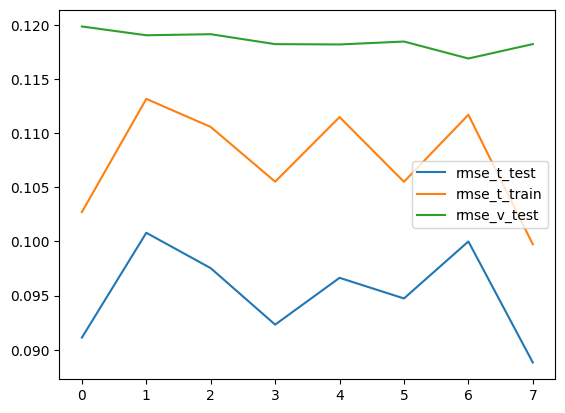

In [37]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [38]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.088831
rmse_t_train    0.099738
rmse_v_test     0.116881
dtype: object

In [39]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test      0.87424
r2_t_train     0.84981
r2_v_test     0.813222
dtype: object

In [40]:
%%time 

result = do_test_per_month_combos(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time=   3.4s
[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time= 1.2min
CPU times: user 2min 47s, sys: 184 ms, total: 2min 47s
Wall time: 2min 47s


<Axes: >

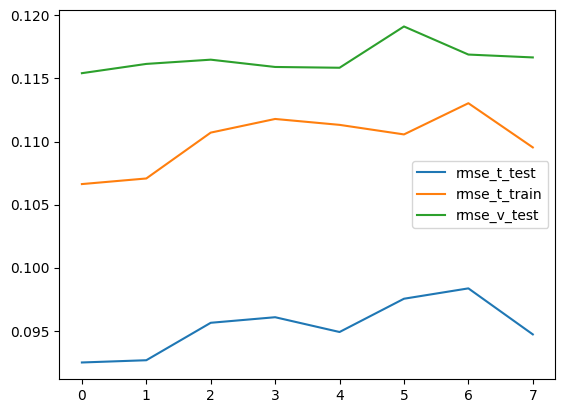

In [41]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [42]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.092479
rmse_t_train    0.106626
rmse_v_test      0.11542
dtype: object

In [43]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.866241
r2_t_train    0.831134
r2_v_test     0.817861
dtype: object

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
%%time 

# define used regressor
forest=RandomForestRegressor(n_estimators=100,
                             max_depth=11,
                             criterion='friedman_mse',
                             n_jobs=10,
                             random_state=config.seed
                            )

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 45.8 µs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 67.4min remaining: 101.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 67.5min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 67.5min finished



  model test
Scores: [-0.11095515 -0.11080108 -0.11053826 -0.11120465 -0.11053231]
Mean: -0.11080628896824754
Standard deviation: 0.00025604114161601637
[CV] END .................................................... total time=67.3min
[CV] END .................................................... total time=67.4min
[CV] END .................................................... total time=67.4min
[CV] END .................................................... total time=67.4min
[CV] END .................................................... total time=67.5min

Training time: 1.826 s
----- EVALUATION ON VAL SET ------
MSE: 0.011999887172261784
RMSE 0.10954399651401159
MAE: 0.07271084164266696
R^2:  0.824473053385494



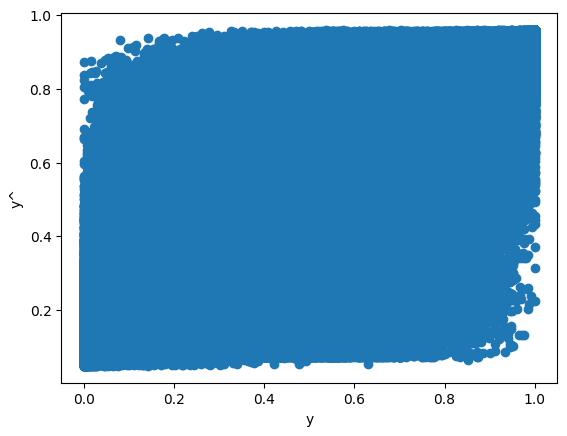


Training time: 0.466 s
----- EVALUATION ON VAL SET ------
MSE: 0.008733016897839134
RMSE 0.09345061207846171
MAE: 0.05949993690308811
R^2:  0.8663906403545428



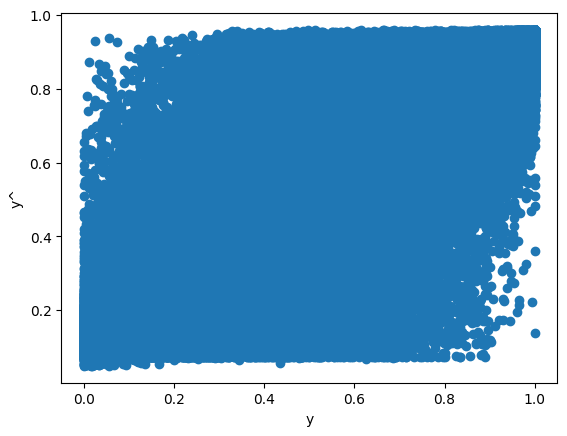


Testing time: 0.274 s
----- EVALUATION ON VAL SET ------
MSE: 0.012899415031338065
RMSE 0.11357559170586815
MAE: 0.07632864270964715
R^2:  0.8236356594824255



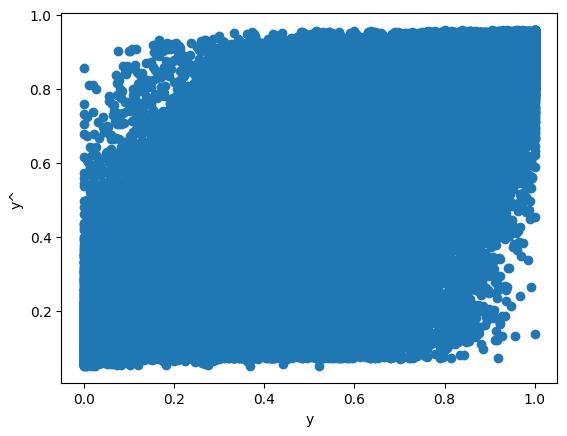

CPU times: user 2h 47min 19s, sys: 2.97 s, total: 2h 47min 22s
Wall time: 1h 24min 21s


{'train': mse_t        0.012
 rmse_t    0.109544
 mae_t     0.072711
 r2_t      0.824473
 dtype: object,
 'test': mse_t     0.008733
 rmse_t    0.093451
 mae_t       0.0595
 r2_t      0.866391
 mse_v     0.012899
 rmse_v    0.113576
 mae_v     0.076329
 r2_v      0.823636
 dtype: object}

In [46]:
%%time

test_model_train_val_test(
    forest, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

In [47]:
%%time 

result = do_test_per_month(
    RandomForestRegressor, dict(n_estimators=100, max_depth=11, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 1h 35min 31s, sys: 280 ms, total: 1h 35min 31s
Wall time: 9min 43s


<Axes: >

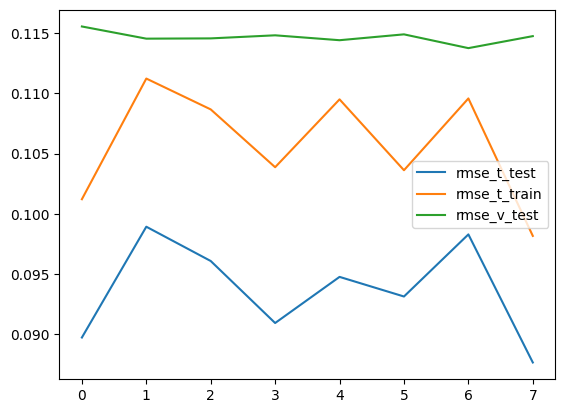

In [48]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [49]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.087643
rmse_t_train    0.098161
rmse_v_test     0.113764
dtype: object

In [50]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.877582
r2_t_train    0.854524
r2_v_test     0.823051
dtype: object

In [51]:
%%time 

result = do_test_per_month_combos(
    RandomForestRegressor, dict(n_estimators=100, max_depth=11, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 5h 28min 42s, sys: 1.09 s, total: 5h 28min 43s
Wall time: 33min 12s


<Axes: >

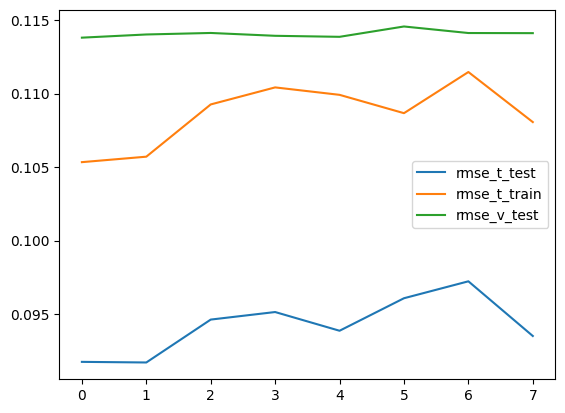

In [52]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [53]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.091702
rmse_t_train    0.105338
rmse_v_test     0.113812
dtype: object

In [54]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.868417
r2_t_train    0.835189
r2_v_test     0.822899
dtype: object

# Gaussian Process

## Gradiend Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
%%time 

boosting = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=11, 
    loss='squared_error',
    criterion='friedman_mse',
    random_state=config.seed,
    verbose=2,
    warm_start=True
)


CPU times: user 0 ns, sys: 47 µs, total: 47 µs
Wall time: 53.9 µs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 53.2min remaining: 79.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 53.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 53.6min finished



  model test
Scores: [-0.10779289 -0.10744204 -0.10736591 -0.10802823 -0.10723625]
Mean: -0.10757306331365987
Standard deviation: 0.00029292310141157066
      Iter       Train Loss   Remaining Time 
         1           0.0577          130.72m
         2           0.0490          128.71m
         3           0.0420          127.42m
      Iter       Train Loss   Remaining Time 
         1           0.0577          118.89m
         2           0.0491          116.39m
         3           0.0420          115.22m
         4           0.0363          113.25m
         5           0.0317          111.40m
         6           0.0280          109.69m
         7           0.0249          108.06m
         8           0.0224          106.40m
         9           0.0204          104.32m
        10           0.0188          102.56m
        11           0.0174          100.69m
        12           0.0163           98.79m
        13           0.0154           96.97m
        14           0.0147       

      Iter       Train Loss   Remaining Time 
         1           0.0577          118.74m
         2           0.0490          118.38m
         3           0.0420          115.90m
         4           0.0363          114.57m
         5           0.0317          113.01m
         6           0.0279          111.41m
         7           0.0249          109.60m
         8           0.0224          107.97m
         9           0.0204          105.82m
        10           0.0187          103.78m
        11           0.0174          101.71m
        12           0.0163           99.62m
        13           0.0154           97.66m
        14           0.0147           95.83m
        15           0.0141           93.86m
        16           0.0136           91.71m
        17           0.0132           89.81m
        18           0.0129           87.58m
        19           0.0126           85.56m
        20           0.0124           83.48m
        21           0.0122           81.32m
        2

      Iter       Train Loss   Remaining Time 
         1           0.0576          121.32m
         2           0.0490          117.82m
         3           0.0420          116.42m
         4           0.0363          114.62m
         5           0.0317          112.70m
         6           0.0279          110.92m
         7           0.0249          109.02m
         8           0.0224          106.90m
         9           0.0204          105.08m
        10           0.0187          103.12m
        11           0.0174          101.19m
        12           0.0163           99.21m
        13           0.0154           97.49m
        14           0.0147           95.49m
        15           0.0141           93.44m
        16           0.0136           91.42m
        17           0.0132           89.54m
        18           0.0129           87.39m
        19           0.0126           85.53m
        20           0.0124           83.48m
        21           0.0122           81.57m
        2

        84           0.0107            9.66m
        85           0.0107            9.01m
        86           0.0107            8.37m
        87           0.0107            7.73m
        88           0.0107            7.10m
        89           0.0107            6.48m
        90           0.0107            5.86m
        91           0.0107            5.25m
        92           0.0107            4.65m
        93           0.0107            4.05m
        94           0.0106            3.46m
        95           0.0106            2.87m
        96           0.0106            2.29m
        97           0.0106            1.71m
        98           0.0106            1.13m
        99           0.0106           33.90s
       100           0.0106            0.00s

Training time: 14.218 s
----- EVALUATION ON VAL SET ------
MSE: 0.010591471456727649
RMSE 0.10291487480790933
MAE: 0.06887391733122378
R^2:  0.8450744895959142



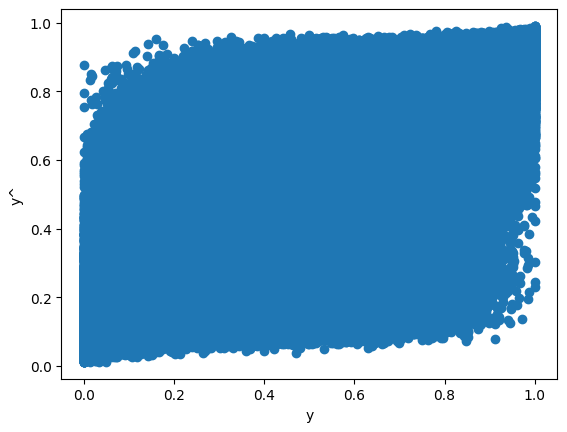


Training time: 3.347 s
----- EVALUATION ON VAL SET ------
MSE: 0.00862861010983279
RMSE 0.09289031224962478
MAE: 0.059485763758865974
R^2:  0.867987994882921



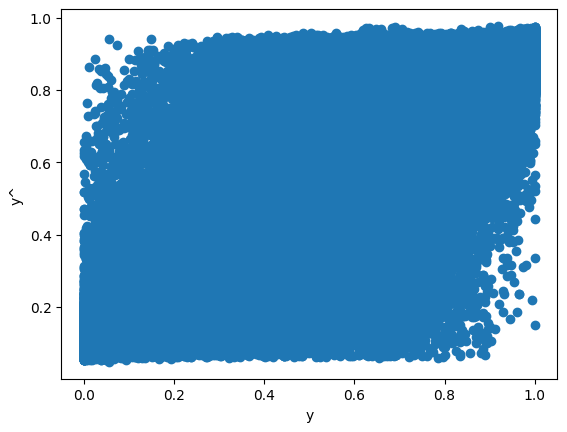


Testing time: 2.123 s
----- EVALUATION ON VAL SET ------
MSE: 0.012307236046109938
RMSE 0.11093798288282485
MAE: 0.07497459500177342
R^2:  0.8317320929985499



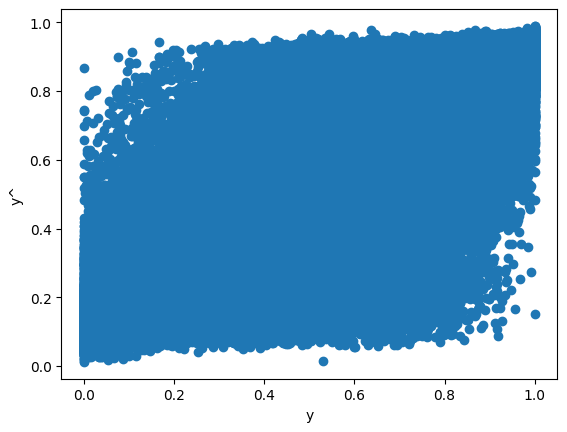

CPU times: user 56min 44s, sys: 2.35 s, total: 56min 47s
Wall time: 1h 50min 18s


{'train': mse_t     0.010591
 rmse_t    0.102915
 mae_t     0.068874
 r2_t      0.845074
 dtype: object,
 'test': mse_t     0.008629
 rmse_t     0.09289
 mae_t     0.059486
 r2_t      0.867988
 mse_v     0.012307
 rmse_v    0.110938
 mae_v     0.074975
 r2_v      0.831732
 dtype: object}

In [24]:
%%time 

test_model_train_val_test(
    boosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

In [58]:
%%time 

result = do_test_per_month(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=0
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

# CPU times: user 38min 55s, sys: 196 ms, total: 38min 55s
# Wall time: 38min 54s

  0%|          | 0/8 [00:00<?, ?months/s]

      Iter       Train Loss   Remaining Time 
         1           0.0514           11.03m
         2           0.0436           10.87m
         3           0.0373           10.72m
         4           0.0322           10.56m
         5           0.0280           10.43m
         6           0.0246           10.28m
         7           0.0218           10.13m
         8           0.0196            9.95m
         9           0.0177            9.79m
        10           0.0162            9.61m
        11           0.0150            9.45m
        12           0.0140            9.24m
        13           0.0131            9.05m
        14           0.0124            8.87m
        15           0.0119            8.69m
        16           0.0114            8.50m
        17           0.0110            8.31m
        18           0.0107            8.11m
        19           0.0104            7.93m
        20           0.0102            7.74m
        21           0.0100            7.56m
        2

        82           0.0097           50.83s
        83           0.0097           47.72s
        84           0.0097           44.65s
        85           0.0097           41.62s
        86           0.0097           38.63s
        87           0.0097           35.68s
        88           0.0097           32.76s
        89           0.0096           29.88s
        90           0.0096           27.02s
        91           0.0096           24.19s
        92           0.0096           21.40s
        93           0.0096           18.63s
        94           0.0096           15.89s
        95           0.0096           13.19s
        96           0.0095           10.50s
        97           0.0095            7.84s
        98           0.0095            5.20s
        99           0.0095            2.59s
       100           0.0095            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0550           11.52m
         2           0.0468           11.33m
         

        63           0.0087            2.23m
        64           0.0087            2.15m
        65           0.0087            2.08m
        66           0.0087            2.00m
        67           0.0086            1.93m
        68           0.0086            1.85m
        69           0.0086            1.78m
        70           0.0086            1.71m
        71           0.0086            1.64m
        72           0.0086            1.57m
        73           0.0086            1.51m
        74           0.0086            1.44m
        75           0.0086            1.37m
        76           0.0085            1.31m
        77           0.0085            1.25m
        78           0.0085            1.18m
        79           0.0085            1.12m
        80           0.0085            1.06m
        81           0.0085            1.00m
        82           0.0085           56.67s
        83           0.0085           53.21s
        84           0.0085           49.79s
        85

        44           0.0091            3.77m
        45           0.0091            3.66m
        46           0.0091            3.55m
        47           0.0091            3.45m
        48           0.0090            3.34m
        49           0.0090            3.24m
        50           0.0090            3.15m
        51           0.0090            3.05m
        52           0.0090            2.96m
        53           0.0089            2.87m
        54           0.0089            2.78m
        55           0.0089            2.70m
        56           0.0089            2.61m
        57           0.0089            2.53m
        58           0.0088            2.45m
        59           0.0088            2.37m
        60           0.0088            2.29m
        61           0.0088            2.21m
        62           0.0088            2.14m
        63           0.0088            2.07m
        64           0.0088            1.99m
        65           0.0087            1.92m
        66

        25           0.0090            7.11m
        26           0.0089            6.93m
        27           0.0088            6.73m
        28           0.0087            6.56m
        29           0.0087            6.38m
        30           0.0086            6.21m
        31           0.0085            6.04m
        32           0.0085            5.87m
        33           0.0085            5.71m
        34           0.0084            5.55m
        35           0.0084            5.40m
        36           0.0083            5.26m
        37           0.0083            5.11m
        38           0.0083            4.97m
        39           0.0083            4.82m
        40           0.0082            4.68m
        41           0.0082            4.54m
        42           0.0082            4.41m
        43           0.0082            4.29m
        44           0.0081            4.18m
        45           0.0081            4.05m
        46           0.0081            3.93m
        47

<Axes: >

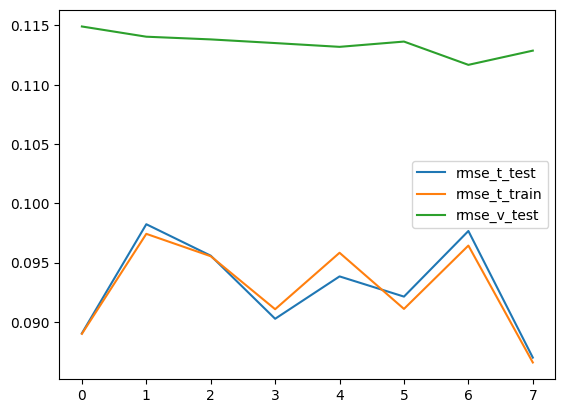

In [59]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [60]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.086984
rmse_t_train    0.086571
rmse_v_test      0.11168
dtype: object

In [61]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.879415
r2_t_train    0.886847
r2_v_test     0.829473
dtype: object

In [62]:
%%time 

result = do_test_per_month_combos(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=2
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12, 1, 2],[1,2,3], [2,3,4], [3,4,5], [3], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

      Iter       Train Loss   Remaining Time 
         1           0.0567           40.62m
         2           0.0481           40.42m
         3           0.0411           39.84m
         4           0.0354           39.30m
         5           0.0308           38.66m
         6           0.0270           38.06m
         7           0.0240           37.48m
         8           0.0215           36.82m
         9           0.0195           36.12m
        10           0.0178           35.49m
        11           0.0165           34.85m
        12           0.0154           34.25m
        13           0.0145           33.61m
        14           0.0138           32.94m
        15           0.0132           32.28m
        16           0.0127           31.61m
        17           0.0123           30.93m
        18           0.0119           30.18m
        19           0.0116           29.51m
        20           0.0114           28.76m
        21           0.0112           28.08m
        2

        82           0.0096            3.31m
        83           0.0096            3.11m
        84           0.0095            2.92m
        85           0.0095            2.72m
        86           0.0095            2.53m
        87           0.0095            2.33m
        88           0.0095            2.14m
        89           0.0095            1.96m
        90           0.0095            1.77m
        91           0.0095            1.58m
        92           0.0095            1.40m
        93           0.0095            1.22m
        94           0.0095            1.04m
        95           0.0095           51.81s
        96           0.0095           41.26s
        97           0.0095           30.80s
        98           0.0094           20.48s
        99           0.0094           10.19s
       100           0.0094            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0555           39.04m
         2           0.0472           38.47m
         

        63           0.0106            7.73m
        64           0.0106            7.46m
        65           0.0106            7.19m
        66           0.0106            6.93m
        67           0.0106            6.67m
        68           0.0106            6.42m
        69           0.0106            6.18m
        70           0.0105            5.93m
        71           0.0105            5.70m
        72           0.0105            5.46m
        73           0.0105            5.23m
        74           0.0105            5.00m
        75           0.0105            4.78m
        76           0.0105            4.56m
        77           0.0105            4.34m
        78           0.0105            4.13m
        79           0.0105            3.92m
        80           0.0105            3.71m
        81           0.0104            3.50m
        82           0.0104            3.30m
        83           0.0104            3.10m
        84           0.0104            2.90m
        85

        44           0.0100            4.16m
        45           0.0100            4.05m
        46           0.0099            3.92m
        47           0.0099            3.81m
        48           0.0099            3.69m
        49           0.0099            3.59m
        50           0.0098            3.48m
        51           0.0098            3.38m
        52           0.0098            3.27m
        53           0.0098            3.17m
        54           0.0097            3.07m
        55           0.0097            2.98m
        56           0.0097            2.88m
        57           0.0097            2.79m
        58           0.0097            2.69m
        59           0.0097            2.61m
        60           0.0096            2.52m
        61           0.0096            2.43m
        62           0.0096            2.35m
        63           0.0096            2.27m
        64           0.0096            2.18m
        65           0.0096            2.11m
        66

        25           0.0111           16.02m
        26           0.0110           15.59m
        27           0.0109           15.16m
        28           0.0109           14.76m
        29           0.0108           14.35m
        30           0.0107           13.97m
        31           0.0107           13.59m
        32           0.0106           13.24m
        33           0.0106           12.86m
        34           0.0106           12.50m
        35           0.0105           12.15m
        36           0.0105           11.77m
        37           0.0105           11.44m
        38           0.0104           11.10m
        39           0.0104           10.77m
        40           0.0104           10.45m
        41           0.0104           10.14m
        42           0.0103            9.84m
        43           0.0103            9.55m
        44           0.0103            9.28m
        45           0.0103            9.01m
        46           0.0102            8.74m
        47

<Axes: >

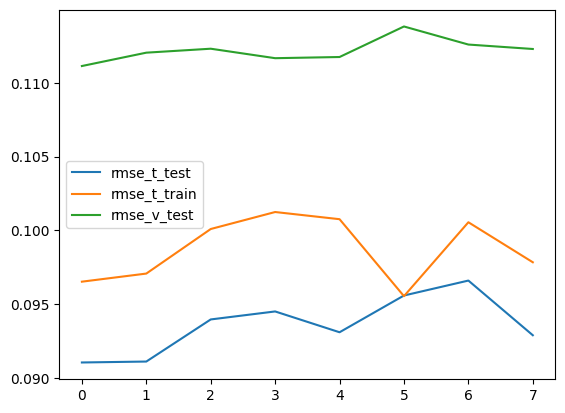

In [63]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

In [64]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.091039
rmse_t_train    0.095536
rmse_v_test     0.111145
dtype: object

In [65]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.870375
r2_t_train    0.861631
r2_v_test     0.831104
dtype: object

# Fine tunning Gradient boosting

In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [26]:
%%time 

hist_boosting = HistGradientBoostingRegressor(
    max_iter=100,
    loss='squared_error',
    random_state=config.seed,
    verbose=2,
    validation_fraction=0.2,
    n_iter_no_change=10,
    warm_start=True,
    l2_regularization=0.001
)


CPU times: user 21 µs, sys: 5 µs, total: 26 µs
Wall time: 28.8 µs


In [ ]:
# Failiing due to memory

In [ ]:
%%time 

test_model_train_val_test(
    hist_boosting, 
    (X_train_prepared.toarray(), y_train_prepared),
    (X_val_prepared.toarray(), y_val_prepared),
    (X_test_prepared.toarray(),  y_test_prepared),
    show=True
)

In [ ]:
GridSearchCV

## Generate Sample

In [80]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [81]:
sample_data

,index,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear,festius,festius_sun,festius_sun_sat,weekend,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,capacity
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0,0,0,0,12.5,18.4,8.0,59.0,0.0,959.4,15.1,3.5,259.0,11.5,262.0,91.0,46.0,961.7,956.7,12.8,20.9,5.8,71.0,93.0,40.0,13.9,20.6,8.7,61.0,0.0,1003.7,15.9,1.5,170.0,10.8,293.0,80.0,39.0,1006.1,1000.6,13.3,20.2,6.5,61.0,0.0,997.9,13.7,1.8,264.0,10.0,262.0,84.0,41.0,1000.2,995.0,27
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0,0,0,0,16.6,24.4,11.4,61.0,0.0,967.8,17.3,3.9,249.0,11.3,247.0,93.0,29.0,969.5,965.6,16.5,26.2,13.2,72.0,90.0,26.0,16.7,25.4,13.2,70.0,0.0,1011.9,16.8,2.5,28.0,9.7,300.0,96.0,25.0,1014.2,1009.8,17.1,26.3,12.0,67.0,0.0,1006.1,17.4,2.6,66.0,10.1,311.0,100.0,25.0,1008.3,1004.0,28
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0,0,1,1,8.2,15.5,3.8,61.0,0.0,970.6,17.8,5.5,294.0,12.9,314.0,73.0,40.0,972.1,969.2,10.0,15.5,5.1,61.0,81.0,37.0,10.9,14.6,7.3,52.0,0.0,1016.0,17.5,1.9,260.0,7.0,227.0,65.0,36.0,1017.6,1014.4,9.6,14.9,5.8,57.0,0.0,1010.1,17.3,2.3,287.0,9.1,291.0,80.0,38.0,1011.5,1008.6,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22.2,13.5,44.0,0.0,1010.1,19.5,3.3,345.0,15.6,337.0,73.0,21.0,1014.2,1005.2,16.5,22.3,10.9,42.0,0.0,1004.3,19.5,3.9,321.0,14.0,307.0,83.0,22.0,1008.3,1000.0,28
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60,0,0,0,0,5.3,11.5,0.7,48.0,0.0,966.2,17.7,5.9,297.0,13.0,321.0,63.0,30.0,968.1,964.1,7.9,12.6,3.3,43.0,58.0,26.0,8.2,11.4,4.5,38.0,0.0,1011.9,17.6,2.0,284.0,8.5,231.0,49.0,25.0,1013.6,1009.5,7.0,11.8,1.7,41.0,0.0,1006.0,17.5,2.7,265.0,11.4,298.0,57.0,25.0,1007.6,1003.7,27
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79,0,0,0,0,12.5,18.2,9.2,77.0,0.0,972.2,20.2,2.9,138.0,9.3,285.0,99.0,38.0,974.2,971.0,14.2,18.5,10.2,76.0,90.0,48.0,14.4,17.2,12.0,72.0,0.0,1017.2,19.9,1.7,130.0,6.6,106.0,87.0,43.0,1019.4,1015.8,14.1,19.3,9.6,70.0,0.0,1011.2,19.0,2.0,180.0,6.6,138.0,94.0,35.0,1013.5,1010.0,51
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22

# apply pipeline

In [82]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

x_train_prepared: (2357330, 421) y_train:  (2357330,)
x_test_prepared: (586724, 421) y_test:  (586724,)
x_test_prepared: (359126, 421) y_test:  (359126,)
x_test_prepared: (54999, 421)


# Prediction 

In [83]:
%%time 

model = boosting

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.2 µs


In [84]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 0

In [85]:
name

'RandomForestRegressor'

In [86]:
yhat = model.predict(X_sample_prepared)

In [87]:
yhat.shape

(54999,)

In [88]:
sample_data['percentage_docks_available'] = yhat

In [89]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')

In [90]:

aux = X_test[X_test.month.isin([3]) & X_test.station_id.isin(sample_data.station_id.unique())][['station_id', 'year', 'month','day','hour', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']]


In [91]:
sample_data = sample_data.merge(aux,
                                on=['station_id','month','day','hour'],
                                how='left')

In [92]:

sample_data[['station_id', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx0', 'ctx1_x', 'ctx1_y', 'ctx4_x', 'ctx4_y', 'ctx3_x', 'ctx3_y', 'ctx2_x', 'ctx2_y']]



,station_id,month,day,hour,percentage_docks_available,ctx0,ctx1_x,ctx1_y,ctx4_x,ctx4_y,ctx3_x,ctx3_y,ctx2_x,ctx2_y
0,394,3,7,8,0.812107,0.693603,0.824074,0.820513,0.753086,0.753086,0.780864,0.777778,0.799383,0.802469
1,337,3,23,12,0.632933,0.673913,0.601449,0.619565,0.463768,0.456522,0.536232,0.530435,0.532609,0.539130
2,368,3,31,1,0.593678,0.562963,0.601852,0.601852,0.787037,0.787037,0.709877,0.709877,0.611111,0.600823
3,327,3,23,15,0.701407,0.883333,0.736111,0.722222,0.753472,0.760417,0.809028,0.812500,0.819444,0.802083
4,328,3,4,20,0.802353,0.759259,0.827160,0.827160,0.861111,0.861111,0.802469,0.802469,0.814815,0.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478761,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261
54995,280,3,1,5,0.135462,0.067901,0.077160,0.077160,0.098765,0.098765,0.074074,0.074074,0.074074,0.074074
54996,180,3,20,16,0.755953,0.820728,0.777778,0.780392,0.782680,0.777778,0.821895,0.852941,0.812092,0.810458
54997,277,3,14,11,0.504856,0.722222,0.472222,0.451852,0.774691,0.703704,0.953704,0.958333,0.972222,0.990741


<Axes: >

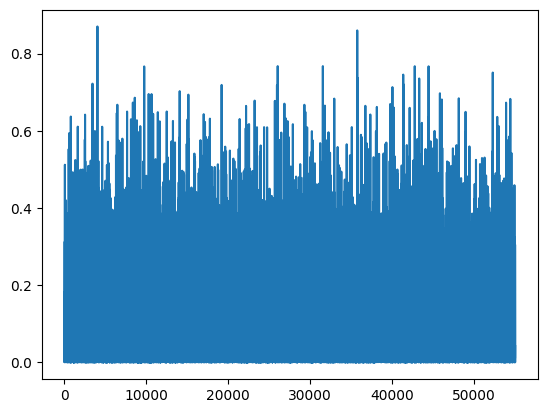

In [93]:
np.abs(sample_data['percentage_docks_available'] - sample_data['ctx0']).plot()